# 1 Data and libraries

In [1]:
# Base
import numpy as np
import pandas as pd
from tqdm import tqdm

# Nice plots
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

## 1.1 Presentation

In [36]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

display(train)

train.info()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Our goal will be to predict the target `Response`.

## 1.2 Exploratory analysis

First, let us have a look at the correlations between our regressors.

In [37]:
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,381106,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,381107,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,381108,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


<Axes: xlabel='Previously_Insured', ylabel='count'>

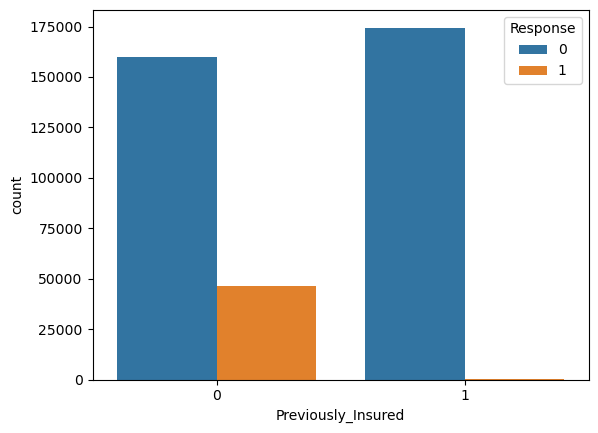

In [42]:
sns.countplot(train,x="Previously_Insured",hue="Response")

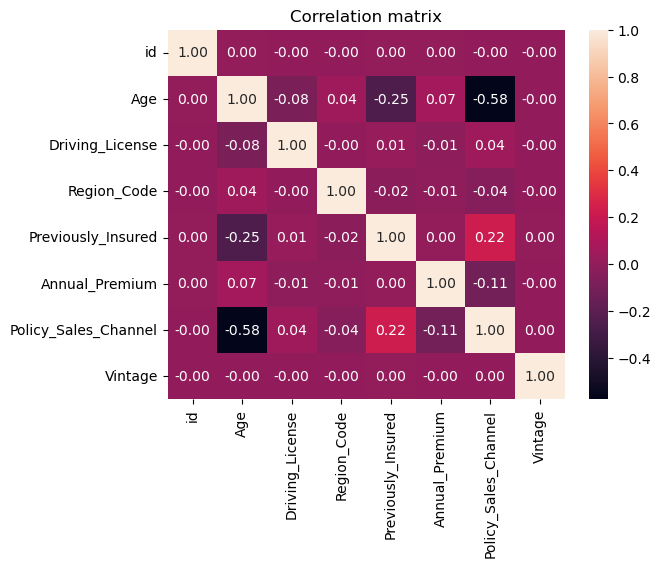

In [7]:
correlations = train.drop(['Response'], axis=1).corr(numeric_only=True)
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title("Correlation matrix")
plt.show()

What can we say about the correlations of the regressors with the targets?

In [8]:
train.corr(numeric_only=True).iloc[:-1, -1]

id                     -0.001368
Age                     0.111147
Driving_License         0.010155
Region_Code             0.010570
Previously_Insured     -0.341170
Annual_Premium          0.022575
Policy_Sales_Channel   -0.139042
Vintage                -0.001050
Name: Response, dtype: float64

What can we say about the target in itself?

In [9]:
counts = train['Response'].value_counts()
print(f'There are {counts[1]} responses (Response = 1) for a total training set of size {counts.sum()}. This corresponds to a ratio of {counts[1]/counts.sum()}.')
print(f'This means that a dumb classifier would at least show an accuracy of at least {counts[0]/counts.sum()}')

There are 46710 responses (Response = 1) for a total training set of size 381109. This corresponds to a ratio of 0.12256336113815208.
This means that a dumb classifier would at least show an accuracy of at least 0.877436638861848


## 1.3 Features engineering

In [10]:
train = train.drop(['id'], axis=1)

train['Gender'] = train['Gender'].map({'Male': 1, 'Female': 0})
train['Vehicle_Damage'] = train['Vehicle_Damage'].map({'Yes': 1, 'No': 0})
train['Vehicle_Age'] = train['Vehicle_Age'].map({'> 2 Years': 2, '1-2 Year': 1, '< 1 Year': 0})


train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  int64  
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  int64  
 6   Vehicle_Damage        381109 non-null  int64  
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 32.0 MB


In [11]:
def remove_outliers(df, col_name):
    q25 = df[col_name].quantile(0.25)
    q75 = df[col_name].quantile(0.75)
    
    cut_off = 1.5 * (q75 - q25)
    lower, upper = max(0, q25 - cut_off), q75 + cut_off
    
    df.loc[df[col_name] > upper, col_name] = upper
    df.loc[df[col_name] < lower, col_name] = lower
    
    return df[col_name]

train['Annual_Premium'] = remove_outliers(train, 'Annual_Premium')

<Axes: xlabel='Annual_Premium'>

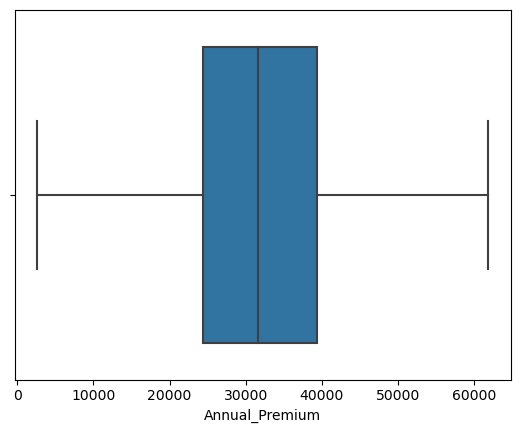

In [12]:
sns.boxplot(train,x="Annual_Premium")

In [13]:
train["Annual_Premium"].describe()

count    381109.000000
mean      30148.169353
std       15476.398118
min        2630.000000
25%       24405.000000
50%       31669.000000
75%       39400.000000
max       61892.500000
Name: Annual_Premium, dtype: float64

In [14]:
train["Annual_Premium"].value_counts()

2630.0     64877
61892.5    10320
39008.0       41
38287.0       38
45179.0       38
           ...  
18146.0        1
49718.0        1
52976.0        1
16380.0        1
20706.0        1
Name: Annual_Premium, Length: 41668, dtype: int64

In [15]:
train['Annual_Premium'].value_counts()

2630.0     64877
61892.5    10320
39008.0       41
38287.0       38
45179.0       38
           ...  
18146.0        1
49718.0        1
52976.0        1
16380.0        1
20706.0        1
Name: Annual_Premium, Length: 41668, dtype: int64

# 2 Model selection 

## 2.1 Random forest / XGBoost

In [16]:
    def print_metrics(y_true, y_pred):
        acc = accuracy_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        pre = precision_score(y_true, y_pred)
        bal=balanced_accuracy_score(y_true,y_pred)
        f1 = f1_score(y_true, y_pred)
        print(f'Accuracy: {acc}\nRecall: {rec}\nPrecision: {pre}\nF1-score: {f1}\nBalanced-Accuracy-Score: {bal}')

In [17]:
X = train.drop(['Response'], axis=1).values
y = train['Response'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

sampler = RandomUnderSampler()
X_train_resampled, y_train_resampled = sampler.fit_resample(X_train_scaled, y_train)

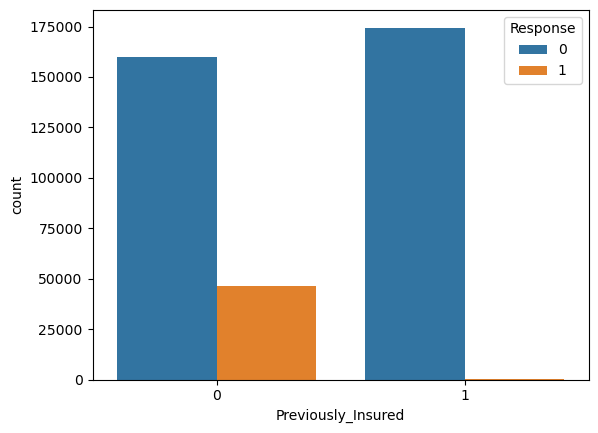

In [59]:
test=sns.countplot(train,x="Previously_Insured",hue="Response")


#sns.heatmap(train.corr(),cmap="viridis",annot=True)

C:\Users\samym\AppData\Local\Temp\ipykernel_15692\4177783059.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr().round(2),cmap="viridis",annot=True)


<Axes: >

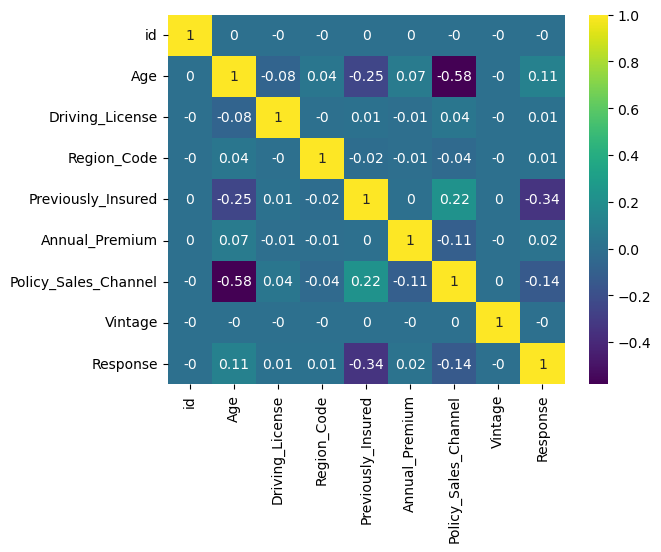

In [61]:
sns.heatmap(train.corr().round(2),cmap="viridis",annot=True)


C:\Users\samym\AppData\Local\Temp\ipykernel_15692\267331650.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plot2= sns.heatmap(train.corr().round(2),cmap="viridis",annot=True)


NameError: name 'st' is not defined

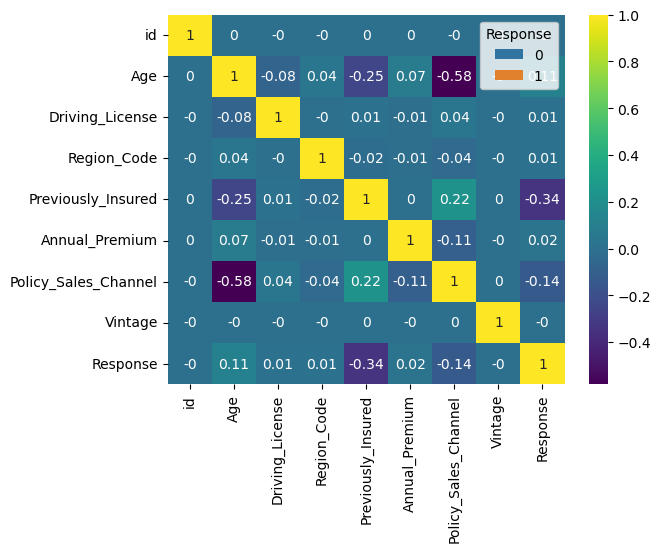

In [52]:


plot=sns.countplot(train,x="Previously_Insured",hue="Response")
plot2= sns.heatmap(train.corr().round(2),cmap="viridis",annot=True)

st.markdown("<h3 style='color: black;'> Quelques graphiques :  </h3>", unsafe_allow_html=True)





plot2= sns.heatmap(train.corr().round(2),cmap="viridis",annot=True)
plt.plot(2)
st.pyplot(plot2.get_figure())


In [18]:
forest = RandomForestClassifier(n_estimators=100, max_depth=3)
forest.fit(X_train_resampled, y_train_resampled)
y_forest = forest.predict(X_test_scaled)
tn_forest, fp_forest, fn_forest, tp_forest = confusion_matrix(y_test, y_forest).ravel()
print("--- Metrics for the Random Forest ---")
print(f'tn = {tn_forest}, fp = {fp_forest}, fn = {fn_forest}, tp = {tp_forest}')
print_metrics(y_test, y_forest)

--- Metrics for the Random Forest ---
tn = 44449, fp = 22284, fn = 794, tp = 8695
Accuracy: 0.6972265225263048
Recall: 0.916324164822426
Precision: 0.28067400497110945
F1-score: 0.42972224967875855
Balanced-Accuracy-Score: 0.7911982114628067


In [19]:
booster = XGBClassifier()
booster.fit(X_train_resampled, y_train_resampled)
y_booster = booster.predict(X_test_scaled)
tn_booster, fp_booster, fn_booster, tp_booster = confusion_matrix(y_test, y_booster).ravel()
print("--- Metrics for the XGBoost ---")
print(f'tn = {tn_booster}, fp = {fp_booster}, fn = {fn_booster}, tp = {tp_booster}')
print_metrics(y_test, y_booster)

--- Metrics for the XGBoost ---
tn = 45089, fp = 21644, fn = 779, tp = 8710
Accuracy: 0.7058198420403557
Recall: 0.9179049425650754
Precision: 0.2869473545496475
F1-score: 0.43721607308686594
Balanced-Accuracy-Score: 0.7967838290815277


## Deep Learning

In [20]:
# Training consists of gradient steps over mini batch of data
def train(model, trainloader, criterion, optimizer, epoch, num_epochs):
    # We enter train mode. This is useless for the linear model
    # but is important for layers such as dropout, batchnorm, ...
    model.train()

    loop = tqdm(trainloader)
#     loop.set_description(f'Training Epoch [{epoch + 1}/{num_epochs}]')

    # We iterate over the mini batches of our data
    for inputs, targets in loop:

        optimizer.zero_grad() # Erase any previously stored gradient
        outputs = model(inputs) # Forwards stage (prediction with current weights)
        targets = targets.view(-1, 1) # Reshape targets to match the output size
        loss = criterion(outputs, targets) # loss evaluation
        loss.backward() # Back propagation (evaluate gradients)

        # Making gradient step on the batch (this function takes care of the gradient step for us)
        optimizer.step()

def validation(model, valloader, criterion):
    # Do not compute gradient, since we do not need it for validation step
    with torch.no_grad():
        
        model.eval() # We enter evaluation mode.

        total, correct = 0, 0 # Keep track of currently used samples
        running_loss = 0.0 # Accumulated loss without averaging

        loop = tqdm(valloader) # This is for the progress bar
#         loop.set_description('Validation in progress')

        # We again iterate over the batches of validation data. batch_size does not play any role here
        for inputs, targets in loop:
            outputs = model(inputs) # Run samples through our net
            total += inputs.shape[0] # Total number of used samples
            predicted = torch.round(outputs)
            targets = targets.view(-1, 1)
            correct += (predicted == targets).sum().item()
            
            # Multiply loss by the batch size to erase averagind on the batch
            batch_loss = criterion(outputs, targets).item()
            running_loss += batch_loss * inputs.shape[0]
            
#             loop.set_postfix(val_loss=(running_loss / total), val_acc=(correct / total)) # Set nice progress message
        return running_loss / total, correct / total

In [21]:
pip install torchviz

Note: you may need to restart the kernel to use updated packages.


In [22]:
class FeedForwardNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_prob=0.5):
        super(FeedForwardNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)  # Dropout layer after first hidden layer
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.dropout2 = nn.Dropout(dropout_prob)  # Dropout layer after second hidden layer
        self.fc3 = nn.Linear(hidden_sizes[1], 1)
        self.sigmoid = nn.Sigmoid()  # Use sigmoid activation for binary classification

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout1(out)  # Applying dropout after first hidden layer
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout2(out)  # Applying dropout after second hidden layer
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [23]:
# Convert data to PyTorch DataLoader
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)  # No need to shuffle for validation

In [24]:
# Set training parameters
num_epochs = 5 # num_epochs indicates the number of passes over the data
criterion = nn.BCELoss()
learning_rate = 0.001

In [47]:
input_size

10

In [48]:
# Settings for the training of FFN
input_size = X_train_tensor.shape[1]
hidden_sizes = [64, 32]
dropout_prob = 0.1

results = np.zeros((40, 11))
k = 0
for hidden_size_1 in [64, 32]:
    for hidden_size_2 in [32, 16]:
        for dropout_prob in np.logspace(-3, -1, 10):
            hidden_sizes = [hidden_size_1, hidden_size_2]
            ffn_model = FeedForwardNet(input_size, hidden_sizes, dropout_prob)
            ffn_optimizer = optim.Adam(ffn_model.parameters(), lr=learning_rate)
            print(f"\n[hidden_sizes = {hidden_sizes}][dropout_prob = {dropout_prob}]")
            for epoch in range(num_epochs):
                # makes one pass over the train data and updates weights
                train(ffn_model, train_loader, criterion, ffn_optimizer, epoch, num_epochs)

                # makes one pass over validation data and provides validation statistics
                val_loss, val_acc = validation(ffn_model, val_loader, criterion)
                
            ffn_model.eval()
            with torch.no_grad():
                y_ffn = ffn_model(X_test_tensor)

            tn, fp, fn, tp = confusion_matrix(y_test, y_ffn.round()).ravel()
            acc = accuracy_score(y_test, y_ffn.round())
            rec = recall_score(y_test, y_ffn.round())
            pre = precision_score(y_test, y_ffn.round())
            f1 = f1_score(y_test, y_ffn.round())
            
            results[k] = hidden_size_1, hidden_size_2, dropout_prob, tn, fp, fn, tp, acc, rec, pre, f1
            print_metrics(y_test, y_ffn.round())
            
            k += 1
results = pd.DataFrame(results, columns=['hidden_size_1', 'hidden_size_2', 'dropout_prob', 'tn', 'fp', 'fn', 'tp', 'acc', 'rec', 'pre', 'f1']).sort_values(by='f1', ascending=False)


[hidden_sizes = [64, 32]][dropout_prob = 0.001]


100%|████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:02<00:00, 2229.96it/s]


Accuracy: 0.682362047702763
Recall: 0.9481212638770282
Precision: 0.27239549789922407
F1-score: 0.4232042882668255
Balanced-Accuracy-Score: 0.7966217352382419

[hidden_sizes = [64, 32]][dropout_prob = 0.0016681005372000592]


100%|████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:02<00:00, 2152.04it/s]


Accuracy: 0.6815223951090237
Recall: 0.9453458582408198
Precision: 0.2714982065667249
F1-score: 0.42184485674137234
Balanced-Accuracy-Score: 0.794949831026055

[hidden_sizes = [64, 32]][dropout_prob = 0.0027825594022071257]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 858.62it/s]


Accuracy: 0.7054918527459264
Recall: 0.9175918018787361
Precision: 0.2839587737843552
F1-score: 0.43370332996972755
Balanced-Accuracy-Score: 0.7966814425673934

[hidden_sizes = [64, 32]][dropout_prob = 0.004641588833612777]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 827.98it/s]


Accuracy: 0.7048227545852903
Recall: 0.9209009393680615
Precision: 0.28392298831660356
F1-score: 0.43403013609035795
Balanced-Accuracy-Score: 0.7977227346195619

[hidden_sizes = [64, 32]][dropout_prob = 0.007742636826811269]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 820.17it/s]


Accuracy: 0.7124845845031618
Recall: 0.9064901793339026
Precision: 0.28756222274897564
F1-score: 0.4366179079153706
Balanced-Accuracy-Score: 0.795894744137888

[hidden_sizes = [64, 32]][dropout_prob = 0.01291549665014884]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 908.37it/s]


Accuracy: 0.6993650127259846
Recall: 0.9264517506404782
Precision: 0.2808283449280052
F1-score: 0.43100836788915653
Balanced-Accuracy-Score: 0.7969979757181211

[hidden_sizes = [64, 32]][dropout_prob = 0.021544346900318832]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 801.35it/s]


Accuracy: 0.7017527747894309
Recall: 0.923462852263023
Precision: 0.28209475983956694
F1-score: 0.43217184963157235
Balanced-Accuracy-Score: 0.7970741131809027

[hidden_sizes = [64, 32]][dropout_prob = 0.03593813663804626]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 811.91it/s]


Accuracy: 0.6944976515966519
Recall: 0.9310418445772843
Precision: 0.27810726356737453
F1-score: 0.428283820279892
Balanced-Accuracy-Score: 0.7961967232878344

[hidden_sizes = [64, 32]][dropout_prob = 0.05994842503189409]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:06<00:00, 792.98it/s]


Accuracy: 0.679187111332686
Recall: 0.9511101622544833
Precision: 0.2707795167907613
F1-score: 0.4215456674473068
Balanced-Accuracy-Score: 0.7960968587321717

[hidden_sizes = [64, 32]][dropout_prob = 0.1]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 834.90it/s]


Accuracy: 0.7061609509065624
Recall: 0.9181255337318531
Precision: 0.28450927855512553
F1-score: 0.4344049092148792
Balanced-Accuracy-Score: 0.7972923417604729

[hidden_sizes = [64, 16]][dropout_prob = 0.001]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 863.65it/s]


Accuracy: 0.7028023405316051
Recall: 0.9231426131511529
Precision: 0.2827899676269579
F1-score: 0.43295201381761744
Balanced-Accuracy-Score: 0.7975347493015166

[hidden_sizes = [64, 16]][dropout_prob = 0.0016681005372000592]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 898.78it/s]


Accuracy: 0.7007425677625883
Recall: 0.9250640478223741
Precision: 0.28160135179047247
F1-score: 0.43176722634647
Balanced-Accuracy-Score: 0.7971866444275361

[hidden_sizes = [64, 16]][dropout_prob = 0.0027825594022071257]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 836.72it/s]


Accuracy: 0.6783999370260555
Recall: 0.9533518360375747
Precision: 0.27057896809767623
F1-score: 0.42152212389380533
Balanced-Accuracy-Score: 0.7966118979152782

[hidden_sizes = [64, 16]][dropout_prob = 0.004641588833612777]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 874.20it/s]


Accuracy: 0.7120647582062921
Recall: 0.9056362083689155
Precision: 0.287135749822317
F1-score: 0.43602723885391237
Balanced-Accuracy-Score: 0.7952882630380791

[hidden_sizes = [64, 16]][dropout_prob = 0.007742636826811269]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:06<00:00, 786.63it/s]


Accuracy: 0.7040355802786598
Recall: 0.922395388556789
Precision: 0.283562497949004
F1-score: 0.43377425265430086
Balanced-Accuracy-Score: 0.79791651439387

[hidden_sizes = [64, 16]][dropout_prob = 0.01291549665014884]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 854.00it/s]


Accuracy: 0.6841725486080135
Recall: 0.9454526046114432
Precision: 0.2732039853172522
F1-score: 0.42391174288654365
Balanced-Accuracy-Score: 0.7965064800063828

[hidden_sizes = [64, 16]][dropout_prob = 0.021544346900318832]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 853.35it/s]


Accuracy: 0.6834903308756002
Recall: 0.944598633646456
Precision: 0.2726544446156216
F1-score: 0.42316428759295127
Balanced-Accuracy-Score: 0.7957504192254776

[hidden_sizes = [64, 16]][dropout_prob = 0.03593813663804626]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 823.35it/s]


Accuracy: 0.7112775838996616
Recall: 0.911400512382579
Precision: 0.2873296314992428
F1-score: 0.436916306322442
Balanced-Accuracy-Score: 0.797317810862663

[hidden_sizes = [64, 16]][dropout_prob = 0.05994842503189409]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 814.55it/s]


Accuracy: 0.6998504368817402
Recall: 0.9253842869342442
Precision: 0.28102308091286304
F1-score: 0.4311219415158146
Balanced-Accuracy-Score: 0.79681575611558

[hidden_sizes = [64, 16]][dropout_prob = 0.1]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:06<00:00, 792.71it/s]


Accuracy: 0.6849466033428669
Recall: 0.9441716481639624
Precision: 0.27353414151410194
F1-score: 0.4241799347784385
Balanced-Accuracy-Score: 0.7963970096505335

[hidden_sizes = [32, 32]][dropout_prob = 0.001]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 853.09it/s]


Accuracy: 0.6903387473432867
Recall: 0.9390478223740393
Precision: 0.2763831725784662
F1-score: 0.4270699322766221
Balanced-Accuracy-Score: 0.7972679504367279

[hidden_sizes = [32, 32]][dropout_prob = 0.0016681005372000592]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 827.94it/s]


Accuracy: 0.7032615255438063
Recall: 0.9209009393680615
Precision: 0.2828153684762654
F1-score: 0.43273475120385235
Balanced-Accuracy-Score: 0.7968327355170399

[hidden_sizes = [32, 32]][dropout_prob = 0.0027825594022071257]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 843.61it/s]


Accuracy: 0.706279027052557
Recall: 0.9183390264731
Precision: 0.28462251042149145
F1-score: 0.43456079203919784
Balanced-Accuracy-Score: 0.79745144101948

[hidden_sizes = [32, 32]][dropout_prob = 0.004641588833612777]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 879.16it/s]


Accuracy: 0.7090603762693186
Recall: 0.9144961571306576
Precision: 0.28611983167457083
F1-score: 0.435868735690664
Balanced-Accuracy-Score: 0.7973847943938506

[hidden_sizes = [32, 32]][dropout_prob = 0.007742636826811269]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:06<00:00, 772.88it/s]


Accuracy: 0.6908897693579281
Recall: 0.9381938514090521
Precision: 0.27663592584432345
F1-score: 0.42728311334743185
Balanced-Accuracy-Score: 0.7972149141569747

[hidden_sizes = [32, 32]][dropout_prob = 0.01291549665014884]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 866.81it/s]


Accuracy: 0.6976463488231744
Recall: 0.9294406490179334
Precision: 0.28003988164157984
F1-score: 0.4304003954522986
Balanced-Accuracy-Score: 0.7973032664421345

[hidden_sizes = [32, 32]][dropout_prob = 0.021544346900318832]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 825.83it/s]


Accuracy: 0.703537036551127
Recall: 0.9214346712211785
Precision: 0.28308136293575575
F1-score: 0.4331050400140488
Balanced-Accuracy-Score: 0.7972192651884754

[hidden_sizes = [32, 32]][dropout_prob = 0.03593813663804626]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:04<00:00, 983.47it/s]


Accuracy: 0.6837264831675894
Recall: 0.9452391118701964
Precision: 0.2728897654781349
F1-score: 0.42351196881651004
Balanced-Accuracy-Score: 0.7961604061460055

[hidden_sizes = [32, 32]][dropout_prob = 0.05994842503189409]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:06<00:00, 788.47it/s]


Accuracy: 0.6987352732806801
Recall: 0.9263450042698548
Precision: 0.2803786630480437
F1-score: 0.4304670254718619
Balanced-Accuracy-Score: 0.7965930902822335

[hidden_sizes = [32, 32]][dropout_prob = 0.1]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 862.53it/s]


Accuracy: 0.6742803914880219
Recall: 0.9517506404782238
Precision: 0.2678201315670902
F1-score: 0.4180126116411543
Balanced-Accuracy-Score: 0.7935750839032157

[hidden_sizes = [32, 16]][dropout_prob = 0.001]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:06<00:00, 790.72it/s]


Accuracy: 0.6816273516832411
Recall: 0.9480145175064048
Precision: 0.2719145157833502
F1-score: 0.4226129577196698
Balanced-Accuracy-Score: 0.7961570179299158

[hidden_sizes = [32, 16]][dropout_prob = 0.0016681005372000592]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 902.93it/s]


Accuracy: 0.7055836897483666
Recall: 0.9176985482493595
Precision: 0.2840387220405062
F1-score: 0.43380850258609815
Balanced-Accuracy-Score: 0.7967796896570338

[hidden_sizes = [32, 16]][dropout_prob = 0.0027825594022071257]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 827.34it/s]


Accuracy: 0.6773766104274357
Recall: 0.9499359521776259
Precision: 0.26949516974046817
F1-score: 0.4198730802802614
Balanced-Accuracy-Score: 0.7945599227187827

[hidden_sizes = [32, 16]][dropout_prob = 0.004641588833612777]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 875.54it/s]


Accuracy: 0.7046259610086327
Recall: 0.9182322801024765
Precision: 0.28342668863261944
F1-score: 0.43315373382345534
Balanced-Accuracy-Score: 0.7964631948273175

[hidden_sizes = [32, 16]][dropout_prob = 0.007742636826811269]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 828.45it/s]


Accuracy: 0.7079845713835901
Recall: 0.9169513236549958
Precision: 0.28566677751912206
F1-score: 0.43562046756934936
Balanced-Accuracy-Score: 0.7978270843302651

[hidden_sizes = [32, 16]][dropout_prob = 0.01291549665014884]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 830.27it/s]


Accuracy: 0.7002571436068327
Recall: 0.9251707941929974
Precision: 0.2812773829227923
F1-score: 0.43139792439212565
Balanced-Accuracy-Score: 0.7969558162187651

[hidden_sizes = [32, 16]][dropout_prob = 0.021544346900318832]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 823.50it/s]


Accuracy: 0.6840019941749101
Recall: 0.945132365499573
Precision: 0.27305248874360083
F1-score: 0.4236971814136
Balanced-Accuracy-Score: 0.7962715706098996

[hidden_sizes = [32, 16]][dropout_prob = 0.03593813663804626]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 839.10it/s]


Accuracy: 0.6960195219228045
Recall: 0.9321093082835183
Precision: 0.2792810081238406
F1-score: 0.4297878623812571
Balanced-Accuracy-Score: 0.7975232274507609

[hidden_sizes = [32, 16]][dropout_prob = 0.05994842503189409]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 808.25it/s]


Accuracy: 0.7069612447849702
Recall: 0.9173783091374893
Precision: 0.2849847459875315
F1-score: 0.43487501265054146
Balanced-Accuracy-Score: 0.7974273003790178

[hidden_sizes = [32, 16]][dropout_prob = 0.1]


100%|█████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:05<00:00, 846.59it/s]


Accuracy: 0.709165332843536
Recall: 0.9140691716481639
Precision: 0.28613914321994255
F1-score: 0.43584262228330023
Balanced-Accuracy-Score: 0.7972610494612615


In [25]:
hidden_sizes=[64,32]
dropout_prob=0.1
input_size=10

In [26]:
#best_params = results.iloc[0]
#hidden_sizes = [best_params['hidden_size_1'].astype(int), best_params['hidden_size_2'].astype(int)]
#dropout_prob = best_params['dropout_prob']

ffn_model = FeedForwardNet(input_size, hidden_sizes, dropout_prob)
ffn_optimizer = optim.Adam(ffn_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    # makes one pass over the train data and updates weights
    train(ffn_model, train_loader, criterion, ffn_optimizer, epoch, num_epochs)

    # makes one pass over validation data and provides validation statistics
    val_loss, val_acc = validation(ffn_model, val_loader, criterion)

ffn_model.eval()
with torch.no_grad():
    y_ffn = ffn_model(X_test_tensor)

tn, fp, fn, tp = confusion_matrix(y_test, y_ffn.round()).ravel()
acc = accuracy_score(y_test, y_ffn.round())
rec = recall_score(y_test, y_ffn.round())
pre = precision_score(y_test, y_ffn.round())
f1 = f1_score(y_test, y_ffn.round())
balanced=balanced_acurracy_score(y_test,y_ffn.round())


print("--- Metrics for the Neural Network ---")
print(f'tn = {tn}, fp = {fp}, fn = {fn}, tp = {tp}')
print_metrics(y_test, y_ffn.round())

100%|████████████████████████████████████████████████████████████████████████████| 4764/4764 [00:03<00:00, 1220.12it/s]


NameError: name 'balanced_acurracy_score' is not defined

In [52]:
results

,hidden_size_1,hidden_size_2,dropout_prob,tn,fp,fn,tp,acc,rec,pre,f1
17,64.0,16.0,0.035938,45677.0,21177.0,830.0,8538.0,0.711278,0.911401,0.287330,0.436916
4,64.0,32.0,0.007743,45815.0,21039.0,876.0,8492.0,0.712485,0.906490,0.287562,0.436618
13,64.0,16.0,0.004642,45791.0,21063.0,884.0,8484.0,0.712065,0.905636,0.287136,0.436027
23,32.0,32.0,0.004642,45479.0,21375.0,801.0,8567.0,0.709060,0.914496,0.286120,0.435869
39,32.0,16.0,0.100000,45491.0,21363.0,805.0,8563.0,0.709165,0.914069,0.286139,0.435843
34,32.0,16.0,0.007743,45374.0,21480.0,778.0,8590.0,0.707985,0.916951,0.285667,0.435620
38,32.0,16.0,0.059948,45292.0,21562.0,774.0,8594.0,0.706961,0.917378,0.284985,0.434875
22,32.0,32.0,0.002783,45231.0,21623.0,765.0,8603.0,0.706279,0.918339,0.284623,0.434561
9,64.0,32.0,0.100000,45224.0,21630.0,767.0,8601.0,0.706161,0.918126,0.284509,0.434405
3,64.0,32.0,0.004642,45096.0,21758.0,741.0,8627.0,0.704823,0.920901,0.283923,0.434030
